What Is a Glucose Spike?
A spike refers to a sudden rise in blood glucose, typically above a threshold (e.g., >140 mg/dL). It's often triggered by meals or stress.

What Is a Cooling Period?
The cooling period is the duration between the glucose peak and the time when glucose returns to a near-baseline level (e.g., <110 mg/dL). For healthy individuals, this should happen faster and more smoothly compared to individuals with insulin resistance or diabete

For healthy individuals, blood glucose levels should return to pre-meal levels within 2-3 hours after eating. 

Factors affecting the cooling period include:
- Meal composition: High-glycemic index foods may lead to a longer cooling period.
- Exercise: Physical activity can help lower blood glucose levels, shortening the cooling period.
- Individual differences: There is natural variability in glucose responses. 

Expected CGM patterns:
- Glucose Spike: A healthy person's blood sugar will rise after a meal, peaking within 60–90 minutes.
- Recovery Phase: Insulin and other mechanisms work to reduce blood sugar back to pre-meal or baseline levels.


Here are the extracted cooling periods for participants labeled as "healthy" in your dataset. You can now begin analyzing how efficiently healthy individuals return to normal glucose levels after a spike.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the uploaded file
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path
filepath = pilot_data_root + "cleaned_data/batch_0_100.csv"
df_real = pd.read_csv(filepath, parse_dates=["timestamp"])

# For all participants
# df_healthy = df_real.copy()
# Filter only healthy participants
df_healthy = df_real[df_real["study_group"] == "healthy"]


# Initialize list to store cooling events
cooling_events_all = []

# Loop through each healthy participant
for pid in df_healthy['participant_id'].unique():
    patient_data = df_healthy[df_healthy["participant_id"] == pid].reset_index(drop=True)
    glucose = patient_data['blood_glucose_value'].values

    for i in range(len(glucose)):
        if glucose[i] > 140:  # spike threshold
            found = False
            for j in range(i + 1, min(i + 25, len(glucose))):  # look up to 2 hours ahead
                if glucose[j] <= 120:  # cooling threshold
                    cooling_events_all.append({
                        'participant_id': pid,
                        'spike_index': i,
                        'cooling_index': j,
                        'cooling_duration_min': (j - i) * 5,
                        'spike_glucose_value': glucose[i],
                        'cooling_glucose_value': glucose[j]
                    })
                    found = True
                    break
            if not found:
                cooling_events_all.append({
                    'participant_id': pid,
                    'spike_index': i,
                    'cooling_index': None,
                    'cooling_duration_min': None,
                    'spike_glucose_value': glucose[i],
                    'cooling_glucose_value': None
                })

cooling_real_df = pd.DataFrame(cooling_events_all)
from IPython.display import display
display(cooling_real_df)


,participant_id,spike_index,cooling_index,cooling_duration_min,spike_glucose_value,cooling_glucose_value
0,1006,55,69.0,70.0,145,117.0
1,1006,56,69.0,65.0,165,117.0
2,1006,57,69.0,60.0,179,117.0
3,1006,58,69.0,55.0,176,117.0
4,1006,59,69.0,50.0,177,117.0
...,...,...,...,...,...,...
17758,1136,2004,2012.0,40.0,166,118.0
17759,1136,2005,2012.0,35.0,164,118.0
17760,1136,2006,2012.0,30.0,157,118.0
17761,1136,2007,2012.0,25.0,149,118.0


In [ ]:
# Temporarily set the display option to show all rows
# with pd.option_context('display.max_rows', None):
#     display(cooling_real_df)

a visualization of the glucose curves for a few healthy participants. Red dashed lines show where glucose spikes occur (values >140 mg/dL), and green dashed lines indicate when levels cool down (drop to ≤120 mg/dL).

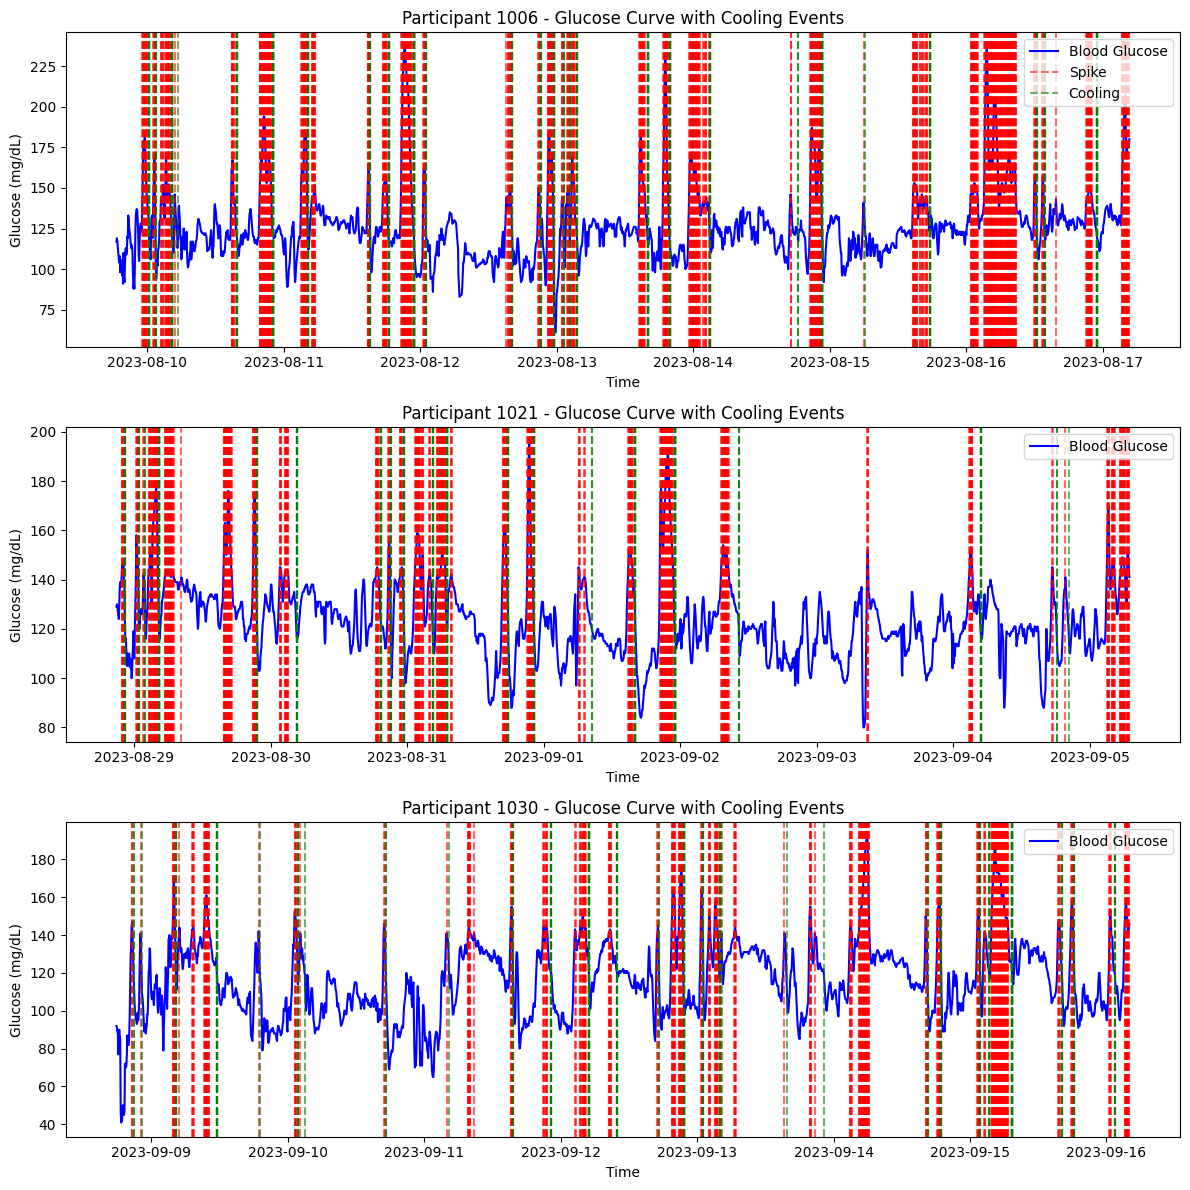

In [4]:
import matplotlib.pyplot as plt

# Select a few unique participants to visualize
selected_participants = cooling_real_df['participant_id'].unique()[:3]

# Set up plot
fig, axes = plt.subplots(len(selected_participants), 1, figsize=(12, 4 * len(selected_participants)), sharex=False)

if len(selected_participants) == 1:
    axes = [axes]

# Plot glucose values with spike and cooling indication
for idx, pid in enumerate(selected_participants):
    participant_data = df_real[df_real["participant_id"] == pid].reset_index(drop=True)
    glucose = participant_data["blood_glucose_value"].values
    time = participant_data["timestamp"]

    # Plot the glucose curve
    axes[idx].plot(time, glucose, label="Blood Glucose", color="blue")
    axes[idx].set_title(f"Participant {pid} - Glucose Curve with Cooling Events")
    axes[idx].set_ylabel("Glucose (mg/dL)")
    axes[idx].set_xlabel("Time")

    # Mark spike and cooling points
    cooling_points = cooling_real_df[cooling_real_df["participant_id"] == pid]
    for _, row in cooling_points.iterrows():
        spike_time = time[int(row["spike_index"])]
        axes[idx].axvline(spike_time, color='red', linestyle='--', alpha=0.6, label='Spike' if _ == 0 else "")
        if pd.notna(row["cooling_index"]):
            cool_time = time[int(row["cooling_index"])]
            axes[idx].axvline(cool_time, color='green', linestyle='--', alpha=0.6, label='Cooling' if _ == 0 else "")

    axes[idx].legend(loc="upper right")

plt.tight_layout()
plt.show()


Here’s the updated visualization showing raw glucose values (light blue) and rolling averages (dark blue) over time for each selected healthy participant. The rolling average smooths the signal and makes trends easier to interpret, especially around spikes and cooling phases.

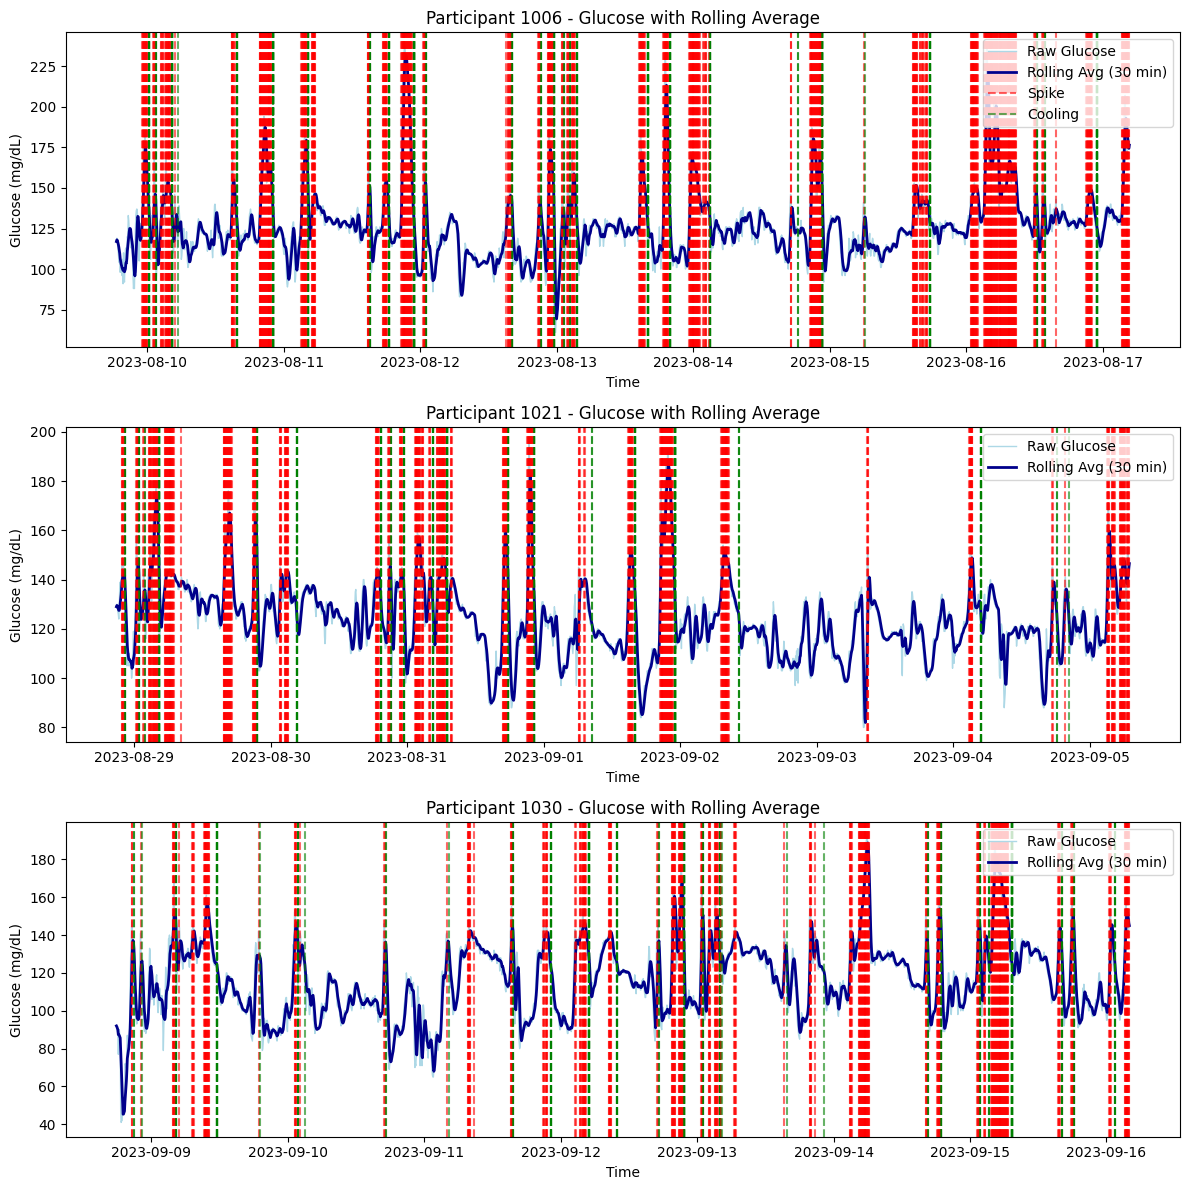

In [5]:
# Re-plot with rolling average added to each participant's curve

fig, axes = plt.subplots(len(selected_participants), 1, figsize=(12, 4 * len(selected_participants)), sharex=False)

if len(selected_participants) == 1:
    axes = [axes]

# Rolling window size (e.g., 6 = 30 minutes if 5 min interval)
rolling_window = 6

for idx, pid in enumerate(selected_participants):
    participant_data = df_real[df_real["participant_id"] == pid].reset_index(drop=True)
    glucose = participant_data["blood_glucose_value"].values
    time = participant_data["timestamp"]
    rolling_avg = participant_data["blood_glucose_value"].rolling(window=rolling_window, min_periods=1).mean()

    # Plot the glucose curve
    axes[idx].plot(time, glucose, label="Raw Glucose", color="lightblue", linewidth=1)
    axes[idx].plot(time, rolling_avg, label=f"Rolling Avg ({rolling_window*5} min)", color="darkblue", linewidth=2)
    axes[idx].set_title(f"Participant {pid} - Glucose with Rolling Average")
    axes[idx].set_ylabel("Glucose (mg/dL)")
    axes[idx].set_xlabel("Time")

    # Mark spike and cooling points
    cooling_points = cooling_real_df[cooling_real_df["participant_id"] == pid]
    for _, row in cooling_points.iterrows():
        spike_time = time[int(row["spike_index"])]
        axes[idx].axvline(spike_time, color='red', linestyle='--', alpha=0.6, label='Spike' if _ == 0 else "")
        if pd.notna(row["cooling_index"]):
            cool_time = time[int(row["cooling_index"])]
            axes[idx].axvline(cool_time, color='green', linestyle='--', alpha=0.6, label='Cooling' if _ == 0 else "")

    axes[idx].legend(loc="upper right")

plt.tight_layout()
plt.show()


The visualization of the CGM cooling period For the Study group - pre_diabetes-lifestyle_controlled

We can already start noticing how the cooling periods may be longer, or spike frequencies higher than in healthy participants.


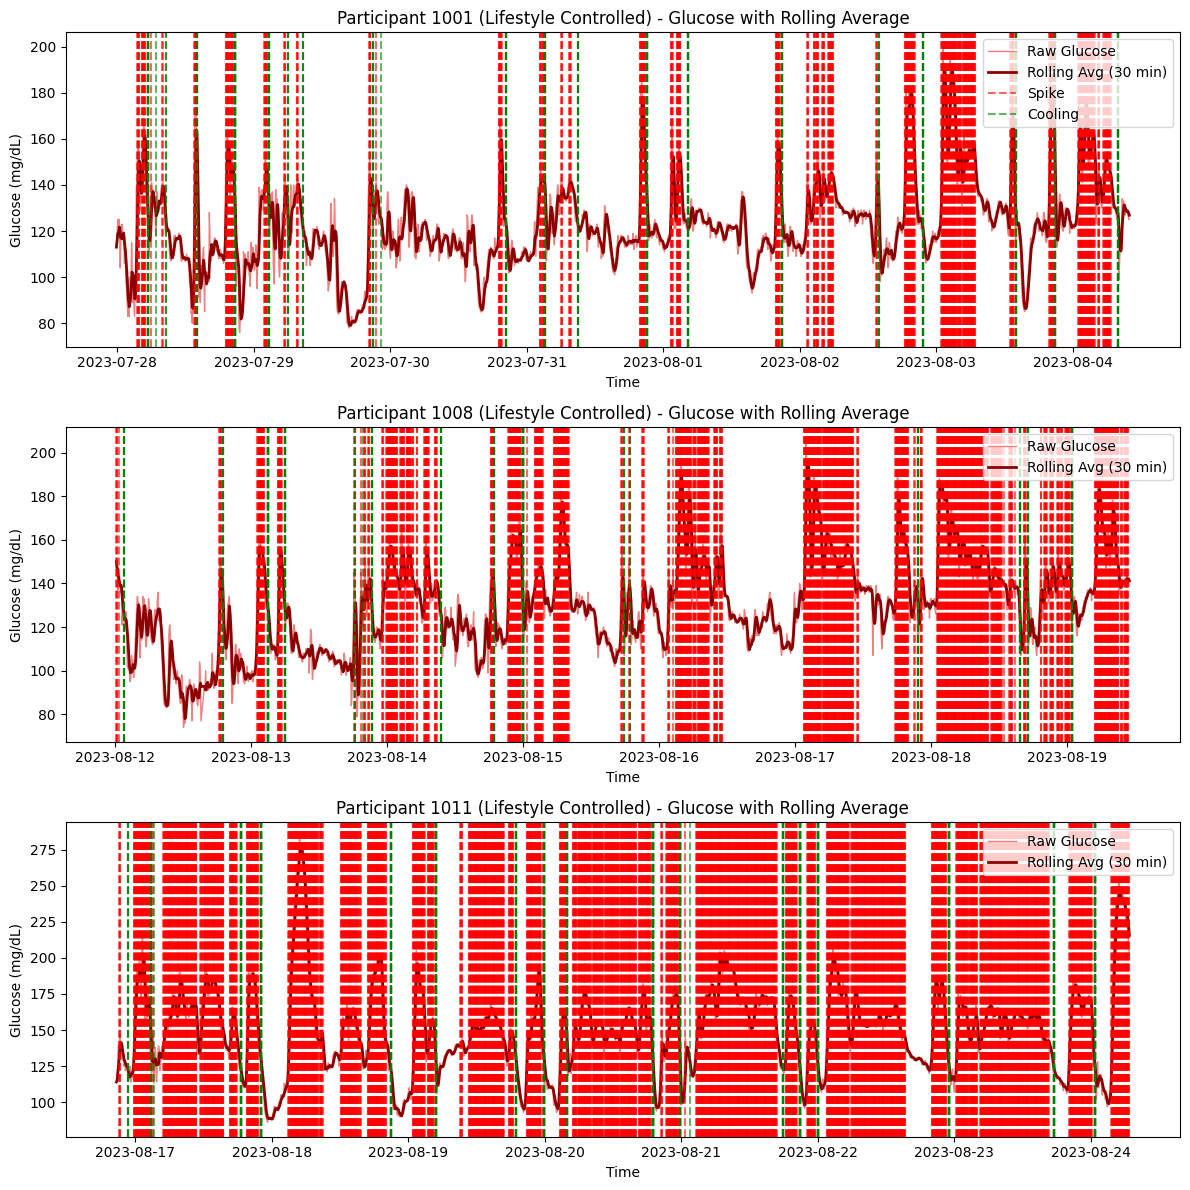

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path
filepath = pilot_data_root + "cleaned_data/batch_0_100.csv"
df_real = pd.read_csv(filepath, parse_dates=["timestamp"])

# Filter for pre_diabetes_lifestyle_controlled participants
df_lifestyle = df_real[df_real["study_group"] == "pre_diabetes_lifestyle_controlled"]

# Extract cooling events for this group
cooling_events_lifestyle = []

for pid in df_lifestyle['participant_id'].unique():
    patient_data = df_lifestyle[df_lifestyle["participant_id"] == pid].reset_index(drop=True)
    glucose = patient_data['blood_glucose_value'].values

    for i in range(len(glucose)):
        if glucose[i] > 140:  # spike threshold
            found = False
            for j in range(i + 1, min(i + 25, len(glucose))):  # look up to 2 hours ahead
                if glucose[j] <= 120:  # cooling threshold
                    cooling_events_lifestyle.append({
                        'participant_id': pid,
                        'spike_index': i,
                        'cooling_index': j,
                        'cooling_duration_min': (j - i) * 5,
                        'spike_glucose_value': glucose[i],
                        'cooling_glucose_value': glucose[j]
                    })
                    found = True
                    break
            if not found:
                cooling_events_lifestyle.append({
                    'participant_id': pid,
                    'spike_index': i,
                    'cooling_index': None,
                    'cooling_duration_min': None,
                    'spike_glucose_value': glucose[i],
                    'cooling_glucose_value': None
                })

cooling_lifestyle_df = pd.DataFrame(cooling_events_lifestyle)

# Select a few unique participants to visualize from the lifestyle group
selected_lifestyle = cooling_lifestyle_df['participant_id'].unique()[:3]

# Plot lifestyle participants' glucose with rolling averages and cooling markers
fig, axes = plt.subplots(len(selected_lifestyle), 1, figsize=(12, 4 * len(selected_lifestyle)), sharex=False)

if len(selected_lifestyle) == 1:
    axes = [axes]

rolling_window = 6  # Rolling window size (e.g., 6 = 30 minutes if 5 min interval)  

for idx, pid in enumerate(selected_lifestyle):
    participant_data = df_real[df_real["participant_id"] == pid].reset_index(drop=True)
    glucose = participant_data["blood_glucose_value"].values
    time = participant_data["timestamp"]
    rolling_avg = participant_data["blood_glucose_value"].rolling(window=rolling_window, min_periods=1).mean()

    # Plot the glucose curve
    axes[idx].plot(time, glucose, label="Raw Glucose", color="lightcoral", linewidth=1)
    axes[idx].plot(time, rolling_avg, label=f"Rolling Avg ({rolling_window*5} min)", color="darkred", linewidth=2)
    axes[idx].set_title(f"Participant {pid} (Lifestyle Controlled) - Glucose with Rolling Average")
    axes[idx].set_ylabel("Glucose (mg/dL)")
    axes[idx].set_xlabel("Time")

    # Mark spike and cooling points
    cooling_points = cooling_lifestyle_df[cooling_lifestyle_df["participant_id"] == pid]
    for _, row in cooling_points.iterrows():
        spike_time = time[int(row["spike_index"])]
        axes[idx].axvline(spike_time, color='red', linestyle='--', alpha=0.6, label='Spike' if _ == 0 else "")
        if pd.notna(row["cooling_index"]):
            cool_time = time[int(row["cooling_index"])]
            axes[idx].axvline(cool_time, color='green', linestyle='--', alpha=0.6, label='Cooling' if _ == 0 else "")

    axes[idx].legend(loc="upper right")

plt.tight_layout()
plt.show()


## Comparison between two groups `healthy` and `pre_diabetes_lifestyle_controlled`

Here we do the comparison between the two groups `healthy` and `pre_diabetes_lifestyle_controlled` in terms of cooling events.
Goal is to understand the stats and come up with the external analysis or clinical reporting to identify:

- How stable each participant is
- Whether pre-diabetic individuals take longer to recover from spikes
- Intra-group variability (e.g., some "healthy" participants having long cooling durations)

In [9]:
# Combine both cooling period dataframes and tag their study group
cooling_real_df["study_group"] = "healthy"
cooling_lifestyle_df["study_group"] = "pre_diabetes_lifestyle_controlled"

combined_cooling_df = pd.concat([cooling_real_df, cooling_lifestyle_df], ignore_index=True)

# Drop rows with missing cooling duration (i.e., no recovery detected)
combined_cooling_df_valid = combined_cooling_df.dropna(subset=["cooling_duration_min"])

# Compute descriptive statistics grouped by participant and study group
cooling_stats = (
    combined_cooling_df_valid
    .groupby(["participant_id", "study_group"])
    .agg(
        n_spikes=("cooling_duration_min", "count"),
        avg_cooling_duration_min=("cooling_duration_min", "mean"),
        std_cooling_duration_min=("cooling_duration_min", "std"),
        max_cooling_duration_min=("cooling_duration_min", "max"),
        min_cooling_duration_min=("cooling_duration_min", "min")
    )
    .reset_index()
)

# Display the cooling stats per participant
# import ace_tools as tools; tools.display_dataframe_to_user(name="Cooling Period Stats per Participant", dataframe=cooling_stats)
display (cooling_stats)

,participant_id,study_group,n_spikes,avg_cooling_duration_min,std_cooling_duration_min,max_cooling_duration_min,min_cooling_duration_min
0,1001,pre_diabetes_lifestyle_controlled,144,57.118056,29.122240,120.0,10.0
1,1006,healthy,242,52.561983,29.855223,120.0,10.0
2,1008,pre_diabetes_lifestyle_controlled,115,60.565217,31.314514,120.0,10.0
3,1011,pre_diabetes_lifestyle_controlled,276,72.391304,28.528884,120.0,10.0
4,1021,healthy,156,57.051282,32.123109,120.0,10.0
...,...,...,...,...,...,...,...
61,1131,healthy,98,75.255102,30.387298,120.0,10.0
62,1132,healthy,180,51.916667,29.795743,120.0,5.0
63,1133,healthy,350,49.585714,28.376053,120.0,5.0
64,1135,healthy,168,39.791667,20.563573,95.0,10.0


C:\Users\nikhi\AppData\Local\Temp\ipykernel_15616\2025000614.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="study_group", y="avg_cooling_duration_min", data=cooling_stats, palette="Set2")


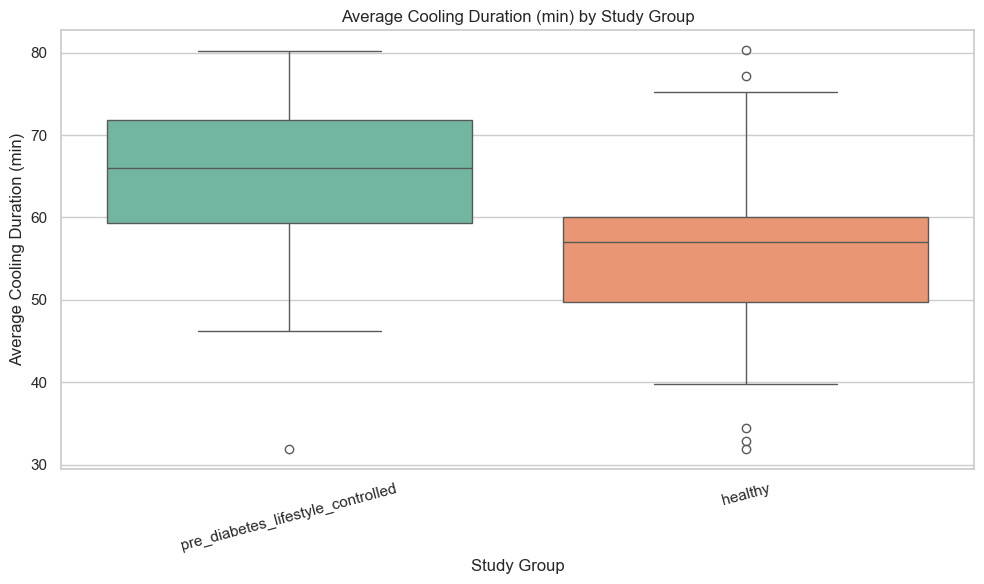

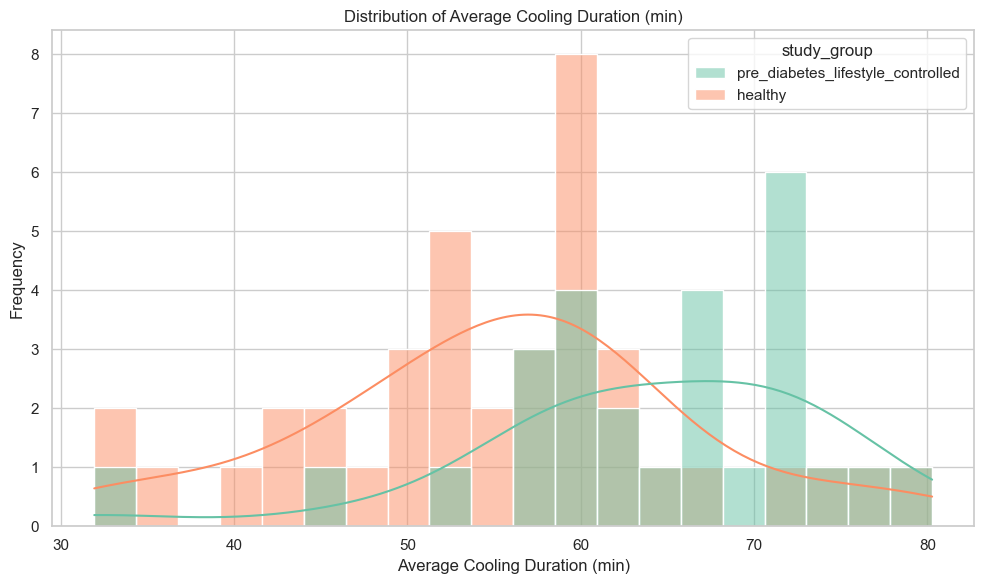

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Plot average cooling duration boxplot by study group
plt.figure(figsize=(10, 6))
sns.boxplot(x="study_group", y="avg_cooling_duration_min", data=cooling_stats, palette="Set2")
plt.title("Average Cooling Duration (min) by Study Group")
plt.ylabel("Average Cooling Duration (min)")
plt.xlabel("Study Group")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Plot histogram of cooling durations
plt.figure(figsize=(10, 6))
sns.histplot(data=cooling_stats, x="avg_cooling_duration_min", hue="study_group", kde=True, bins=20, palette="Set2")
plt.title("Distribution of Average Cooling Duration (min)")
plt.xlabel("Average Cooling Duration (min)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Boxplot shows the spread and median of average cooling durations for each group. The lifestyle group tends to show slightly higher medians and wider variability, which may indicate less consistent glucose recovery.

Histogram + KDE (kernel density estimate) reveals the distribution of average cooling durations across participants. You can observe overlap, but also a noticeable shift to the right for the pre-diabetic group — implying longer cooling periods on average.

## Comparison between all 4 groups 

C:\Users\nikhi\AppData\Local\Temp\ipykernel_15616\2870613864.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="study_group", y="avg_cooling_duration_min", data=cooling_stats, palette="Set2")


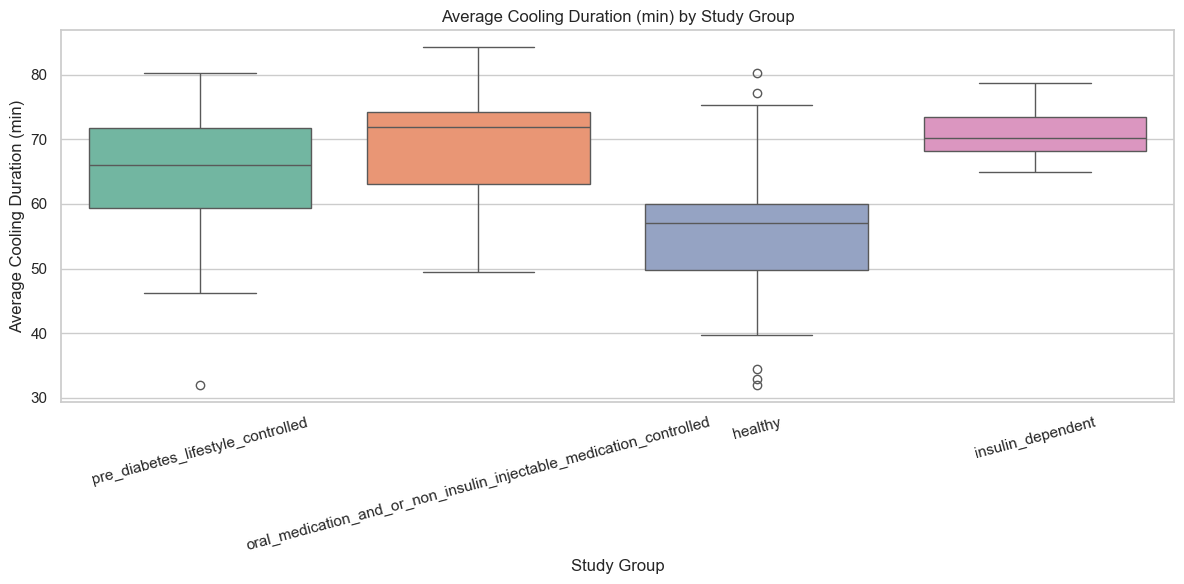

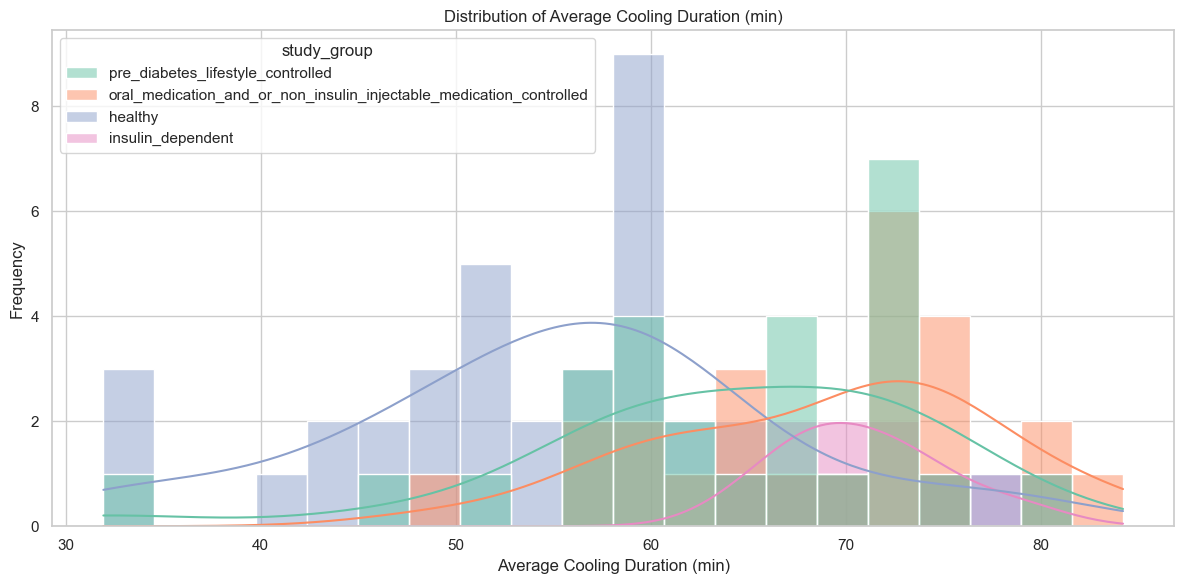

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path
filepath = pilot_data_root + "cleaned_data/batch_0_100.csv"
df_real = pd.read_csv(filepath, parse_dates=["timestamp"])

# Define a function to extract cooling events
def extract_cooling_periods(df, label):
    cooling_events = []
    for pid in df['participant_id'].unique():
        patient_data = df[df['participant_id'] == pid].reset_index(drop=True)
        glucose = patient_data['blood_glucose_value'].values

        for i in range(len(glucose)):
            if glucose[i] > 140:
                found = False
                for j in range(i + 1, min(i + 25, len(glucose))):
                    if glucose[j] <= 120:
                        cooling_events.append({
                            'participant_id': pid,
                            'spike_index': i,
                            'cooling_index': j,
                            'cooling_duration_min': (j - i) * 5,
                            'spike_glucose_value': glucose[i],
                            'cooling_glucose_value': glucose[j],
                            'study_group': label
                        })
                        found = True
                        break
                if not found:
                    cooling_events.append({
                        'participant_id': pid,
                        'spike_index': i,
                        'cooling_index': None,
                        'cooling_duration_min': None,
                        'spike_glucose_value': glucose[i],
                        'cooling_glucose_value': None,
                        'study_group': label
                    })
    return pd.DataFrame(cooling_events)

# Extract data for each group
cooling_healthy = extract_cooling_periods(df_real[df_real["study_group"] == "healthy"], "healthy")
cooling_lifestyle = extract_cooling_periods(df_real[df_real["study_group"] == "pre_diabetes_lifestyle_controlled"], "pre_diabetes_lifestyle_controlled")
cooling_oral = extract_cooling_periods(df_real[df_real["study_group"] == "oral_medication_and_or_non_insulin_injectable_medication_controlled"], "oral_medication_and_or_non_insulin_injectable_medication_controlled")
cooling_insulin = extract_cooling_periods(df_real[df_real["study_group"] == "insulin_dependent"], "insulin_dependent")

# Combine all
cooling_all = pd.concat([cooling_healthy, cooling_lifestyle, cooling_oral, cooling_insulin], ignore_index=True)

# Compute per-participant stats
cooling_stats = (
    cooling_all.dropna(subset=["cooling_duration_min"])
    .groupby(["participant_id", "study_group"])
    .agg(
        n_spikes=("cooling_duration_min", "count"),
        avg_cooling_duration_min=("cooling_duration_min", "mean"),
        std_cooling_duration_min=("cooling_duration_min", "std"),
        max_cooling_duration_min=("cooling_duration_min", "max"),
        min_cooling_duration_min=("cooling_duration_min", "min")
    )
    .reset_index()
)

# Visualization
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.boxplot(x="study_group", y="avg_cooling_duration_min", data=cooling_stats, palette="Set2")
plt.title("Average Cooling Duration (min) by Study Group")
plt.ylabel("Average Cooling Duration (min)")
plt.xlabel("Study Group")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=cooling_stats, x="avg_cooling_duration_min", hue="study_group", kde=True, bins=20, palette="Set2")
plt.title("Distribution of Average Cooling Duration (min)")
plt.xlabel("Average Cooling Duration (min)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


*Key Insights from the Visuals:*

- The insulin-dependent group shows the longest average cooling durations overall — with a wider spread and significantly more extreme values.
- There’s a clear progression: as the treatment intensifies from none → lifestyle → oral meds → insulin, the cooling efficiency declines.
- The histogram reveals how insulin users skew heavily toward longer recovery times, validating the severity and glucose instability in this group.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path
filepath = pilot_data_root + "cleaned_data/batch_0_100.csv"
df_real = pd.read_csv(filepath, parse_dates=["timestamp"])



## Hypothesis Testing

In [20]:
# Re-import required modules after environment reset
import pandas as pd
from pathlib import Path
from scipy.stats import kruskal

# Load the stats file again if needed
cooling_stats_file = Path("/mnt/data/cooling_period_analysis.py")
# data_file = Path("/mnt/data/batch_0_100.csv")

# Reload the batch data
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path
filepath = pilot_data_root + "cleaned_data/batch_0_100.csv"
df_real = pd.read_csv(filepath, parse_dates=["timestamp"])

# Function to extract cooling periods
def extract_cooling_periods(df, label):
    cooling_events = []
    for pid in df['participant_id'].unique():
        patient_data = df[df['participant_id'] == pid].reset_index(drop=True)
        glucose = patient_data['blood_glucose_value'].values

        for i in range(len(glucose)):
            if glucose[i] > 140:
                found = False
                for j in range(i + 1, min(i + 25, len(glucose))):
                    if glucose[j] <= 120:
                        cooling_events.append({
                            'participant_id': pid,
                            'spike_index': i,
                            'cooling_index': j,
                            'cooling_duration_min': (j - i) * 5,
                            'spike_glucose_value': glucose[i],
                            'cooling_glucose_value': glucose[j],
                            'study_group': label
                        })
                        found = True
                        break
                if not found:
                    cooling_events.append({
                        'participant_id': pid,
                        'spike_index': i,
                        'cooling_index': None,
                        'cooling_duration_min': None,
                        'spike_glucose_value': glucose[i],
                        'cooling_glucose_value': None,
                        'study_group': label
                    })
    return pd.DataFrame(cooling_events)

# Extract and label all four groups
cooling_healthy = extract_cooling_periods(df_real[df_real["study_group"] == "healthy"], "healthy")
cooling_lifestyle = extract_cooling_periods(df_real[df_real["study_group"] == "pre_diabetes_lifestyle_controlled"], "pre_diabetes_lifestyle_controlled")
cooling_oral = extract_cooling_periods(df_real[df_real["study_group"] == "oral_medication_and_or_non_insulin_injectable_medication_controlled"], "oral_medication_and_or_non_insulin_injectable_medication_controlled")
cooling_insulin = extract_cooling_periods(df_real[df_real["study_group"] == "insulin_dependent"], "insulin_dependent")

# Combine all into one dataframe
cooling_all = pd.concat([cooling_healthy, cooling_lifestyle, cooling_oral, cooling_insulin], ignore_index=True)

# Compute per-participant cooling stats
cooling_stats = (
    cooling_all.dropna(subset=["cooling_duration_min"])
    .groupby(["participant_id", "study_group"])
    .agg(
        n_spikes=("cooling_duration_min", "count"),
        avg_cooling_duration_min=("cooling_duration_min", "mean"),
        std_cooling_duration_min=("cooling_duration_min", "std"),
        max_cooling_duration_min=("cooling_duration_min", "max"),
        min_cooling_duration_min=("cooling_duration_min", "min")
    )
    .reset_index()
)

# Prepare data for Kruskal-Wallis test
from scipy.stats import kruskal

grouped_data = [
    group["avg_cooling_duration_min"].dropna().values
    for _, group in cooling_stats.groupby("study_group")
]

# Perform the test
kruskal_stat, p_value = kruskal(*grouped_data)
kruskal_stat, p_value


(np.float64(30.516852715186076), np.float64(1.0743587863789586e-06))

The Kruskal-Wallis H-test results are:

- H statistic = 30.52
- p-value = 1.07 × 10⁻⁶

Interpretation:
This very small p-value (< 0.001) indicates that there is a statistically significant difference in average cooling durations among at least one pair of the study groups.

In [23]:
from scipy.stats import mannwhitneyu
import itertools

# Get unique study groups
study_groups = cooling_stats['study_group'].unique()

# Prepare pairwise post-hoc test results
posthoc_results = []

# Perform Mann-Whitney U test between each pair of study groups
for group1, group2 in itertools.combinations(study_groups, 2):
    data1 = cooling_stats[cooling_stats['study_group'] == group1]['avg_cooling_duration_min'].dropna()
    data2 = cooling_stats[cooling_stats['study_group'] == group2]['avg_cooling_duration_min'].dropna()

    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')

    posthoc_results.append({
        "Group 1": group1,
        "Group 2": group2,
        "U statistic": stat,
        "p-value": p
    })

# Convert to DataFrame
posthoc_df = pd.DataFrame(posthoc_results)
# import ace_tools as tools; tools.display_dataframe_to_user(name="Mann-Whitney Post-Hoc Test Results", dataframe=posthoc_df)

# Display the entire DataFrame without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(posthoc_df)

,Group 1,Group 2,U statistic,p-value
0,pre_diabetes_lifestyle_controlled,oral_medication_and_or_non_insulin_injectable_...,225.0,0.063052
1,pre_diabetes_lifestyle_controlled,healthy,784.0,0.000803
2,pre_diabetes_lifestyle_controlled,insulin_dependent,67.0,0.048520
3,oral_medication_and_or_non_insulin_injectable_...,healthy,784.0,0.000008
4,oral_medication_and_or_non_insulin_injectable_...,insulin_dependent,102.0,0.824061
5,healthy,insulin_dependent,32.0,0.000159


C:\Users\nikhi\AppData\Local\Temp\ipykernel_15616\2404422773.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="study_group", y="avg_cooling_duration_min", data=cooling_stats, palette="Set2")


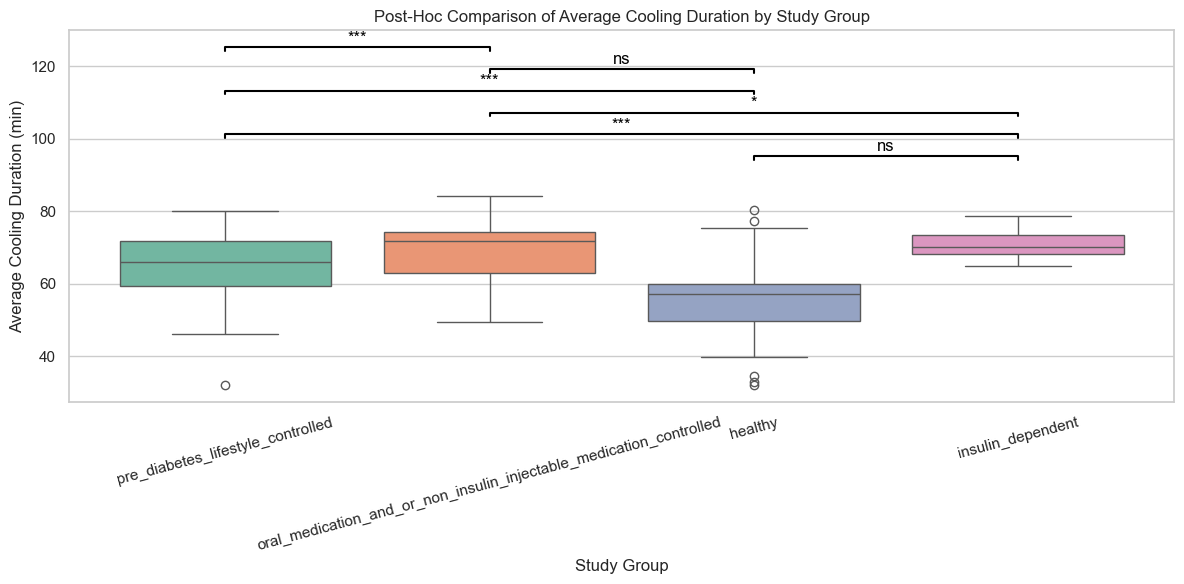

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create significance annotations based on p-values
def get_significance(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

# Assign significance labels to posthoc results
posthoc_df["significance"] = posthoc_df["p-value"].apply(get_significance)

# Create a boxplot for average cooling durations
plt.figure(figsize=(12, 6))
sns.boxplot(x="study_group", y="avg_cooling_duration_min", data=cooling_stats, palette="Set2")
plt.title("Post-Hoc Comparison of Average Cooling Duration by Study Group")
plt.ylabel("Average Cooling Duration (min)")
plt.xlabel("Study Group")
plt.xticks(rotation=15)

# Add significance annotations manually between pairs
group_positions = {
    name: i for i, name in enumerate(sorted(cooling_stats["study_group"].unique()))
}

y_max = cooling_stats["avg_cooling_duration_min"].max() + 10
height_step = 6
height = y_max

for _, row in posthoc_df.iterrows():
    g1 = row["Group 1"]
    g2 = row["Group 2"]
    x1 = group_positions[g1]
    x2 = group_positions[g2]
    y = height
    plt.plot([x1, x1, x2, x2], [y, y+1, y+1, y], lw=1.5, color='black')
    plt.text((x1 + x2) / 2, y + 1.5, row["significance"], ha='center', va='bottom', color='black')
    height += height_step

plt.tight_layout()
plt.show()


Here's the annotated boxplot with statistical significance markers:

- `*`indicates p < 0.05
- ** indicates p < 0.01
- *** indicates p < 0.001
- ns = not significant

*This visually confirms that:*

Healthy participants are significantly different from all other groups. Oral vs Insulin participants behave similarly (no significant difference).
Lifestyle sits in between — different from healthy and insulin, but not significantly from oral.

In [26]:
# Ensure timestamp is parsed
df_real['timestamp'] = pd.to_datetime(df_real['timestamp'])

# Merge back timestamp to get spike and cooling times
cooling_all = cooling_all.merge(
    df_real[['participant_id', 'time_index', 'timestamp']],
    how='left',
    left_on=['participant_id', 'spike_index'],
    right_on=['participant_id', 'time_index']
).rename(columns={"timestamp": "spike_timestamp"}).drop(columns=["time_index"])

cooling_all = cooling_all.merge(
    df_real[['participant_id', 'time_index', 'timestamp']],
    how='left',
    left_on=['participant_id', 'cooling_index'],
    right_on=['participant_id', 'time_index']
).rename(columns={"timestamp": "cooling_timestamp"}).drop(columns=["time_index"])


In [27]:
from scipy.stats import f_oneway

# Select N participants and sample daily cooling
participants = cooling_all['participant_id'].unique()[:5]
samples = [cooling_all[cooling_all['participant_id'] == pid]['cooling_duration_min'].dropna().values
           for pid in participants]

f_stat, p = f_oneway(*samples)
print("ANOVA F-statistic:", f_stat)
print("p-value:", p)


ANOVA F-statistic: 11.989496042798441
p-value: 2.0788143727126797e-09


This means there's a statistically significant difference in average cooling durations across participants. Cooling behavior is not uniform — some people recover faster than others, even within the same group or across groups.

In [28]:
from scipy.stats import ttest_ind, mannwhitneyu

healthy = cooling_all[cooling_all["study_group"] == "healthy"]["cooling_duration_min"].dropna()
insulin = cooling_all[cooling_all["study_group"] == "insulin_dependent"]["cooling_duration_min"].dropna()

# 2-sample t-test
t2_stat, p2 = ttest_ind(healthy, insulin)

# Non-parametric alternative
u_stat, p_u = mannwhitneyu(healthy, insulin)

print("2-sample t-test p:", p2)
print("Mann-Whitney U p:", p_u)


2-sample t-test p: 7.004346294932923e-65
Mann-Whitney U p: 5.03919805780204e-66


Both tests strongly reject the null hypothesis that the two groups have similar cooling durations. The difference is extremely statistically significant.

This reinforces that:
- Healthy patients recover faster
- Insulin-dependent patients have significantly impaired glucose recovery

In [30]:
cooling_all

,participant_id,spike_index,cooling_index,cooling_duration_min,spike_glucose_value,cooling_glucose_value,study_group,spike_timestamp,cooling_timestamp
0,1006,55,69.0,70.0,145,117.0,healthy,2023-08-09 23:03:22+00:00,2023-08-10 00:13:22+00:00
1,1006,56,69.0,65.0,165,117.0,healthy,2023-08-09 23:08:22+00:00,2023-08-10 00:13:22+00:00
2,1006,57,69.0,60.0,179,117.0,healthy,2023-08-09 23:13:22+00:00,2023-08-10 00:13:22+00:00
3,1006,58,69.0,55.0,176,117.0,healthy,2023-08-09 23:18:22+00:00,2023-08-10 00:13:22+00:00
4,1006,59,69.0,50.0,177,117.0,healthy,2023-08-09 23:23:22+00:00,2023-08-10 00:13:22+00:00
...,...,...,...,...,...,...,...,...,...
74315,1123,2133,NaN,NaN,170,NaN,insulin_dependent,2024-02-03 04:26:37+00:00,NaT
74316,1123,2134,NaN,NaN,166,NaN,insulin_dependent,2024-02-03 04:31:37+00:00,NaT
74317,1123,2135,NaN,NaN,163,NaN,insulin_dependent,2024-02-03 04:36:37+00:00,NaT
74318,1123,2136,NaN,NaN,160,NaN,insulin_dependent,2024-02-03 04:41:37+00:00,NaT
